# Challenge 04: QOSF MENTORSHIP PROGRAM SCREENING TASKS

**Solution done by [Billy.Ljm](https://github.com/BillyLjm/QOSF-Monthly-Challenges)**

Since this month coincides with the application window for the QOSF mentorship program, we have decided to make the corresponding screening tasks as the challenge for this month.

There are four separate tasks, so please feel free to try them all!

### Acknowledgements

[Dario Rosa](https://github.com/Dario-Rosa85) was responsible for developing tasks 1 and 2, with suggestions from 
[Anton Simen](https://github.com/AntonSimen06) to implement the SWAP test for task 1. Dario was also responsible for putting together and reviewing the final document with all four tasks, which can be found [here](https://docs.google.com/document/d/1944peQceYXhRA4Usp6ub_l2ms1xj8mXgseCgWpyBZOA)


[Petar Korponaić](https://github.com/perak) was responsible for developing task 3.


[Michał Stęchły](https://github.com/mstechly) was responsible for developing task 4.


[Diego Emilio Serrano](https://github.com/diemilio) and [Stefano Mangini](https://github.com/stfnmangini) reviewed all tasks, and provided feedback for changes implemented in task 2.

## Quantum Programming Package  
All my solutions are implemented in Xanadu's [PennyLane](https://pennylane.ai/) quantum programming package  

In [1]:
import pennylane as qml
from pennylane import numpy as np
np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt
import networkx as nx

## TASK 1

The [Swap test](https://en.wikipedia.org/wiki/Swap_test) is a simple quantum circuit which, given two states, allows to compute how much do they differ from each other.

1) Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

2) Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

3) Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. For example, the state
|a> = |01>
Is a product state, while the state
|b> = |00> + |11>
Is not.

Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.

### Task 1.1
The most general rotation, which can transform between any two arbitrary single qubit states, is $RZ(\omega) RY(\phi) RZ(\theta)$ *(or similar)*  

This can be proven by noting that the product of those rotations can realise any unitary $2 \times 2$ matrix  

$$
RZ(\omega) RY(\phi) RZ(\theta)
= \left(\begin{array}{cc}
e^{-i(\theta+\omega)/2} \cos(\phi/2) & -e^{-i(\theta-\omega)/2} \sin(\phi/2) \\
e^{-i(\theta-\omega)/2} \sin(\phi/2) & e^{i(\theta+\omega)/2} \cos(\phi/2) \\
\end{array}\right)
$$

Alternatively, it can be thought of geometrically as any point on Bloch sphere requiring a zenith and an azimuthal rotation.  
However, the zenith rotation might need to be a $RX$ (or $RY$) if the initial state is along the $X$ (or $Y$) axis.  
Thus, we can choose to add an extra $RZ$ to rotate the initial state away from the axes.   

In [2]:
def qubit_rot(theta, phi, omega, wires):
    """arbritrary single-qubit rotation of RZ(omega)RY(phi)RZ(theta)"""
    qml.RZ(theta, wires=wires)
    qml.RY(phi, wires=wires)
    qml.RZ(omega, wires=wires)

### Task 1.2
To reproduce an unknown single-qubit state, one can simply apply `qubit_rot` on another qubit with very specific parameters.  
These parameters can be variationally approximated by maximising the state overlap, measured via a swap test, between the two qubits.  
These would result in the following parametrised quantum circuit.  

In [3]:
def swap_test(params, wires):
    """Rotates wires[1] with params, and measures its state overlap with wires[2]"""
    # try single qubit rotation
    qubit_rot(*params, wires=wires[1])
    # do swap test
    qml.Hadamard(wires=wires[0])
    qml.CSWAP(wires=wires)
    qml.Hadamard(wires=wires[0])
    return qml.expval(qml.PauliZ(wires[0]))

# draw circuit
dev3 = qml.device('default.qubit', wires=3)
circuit = qml.QNode(lambda x: swap_test(x, wires=range(3)), dev3)
circuit([0,1,2])
print(circuit.draw())

 0: ──H────────────────────╭C─────H──┤ ⟨Z⟩ 
 1: ──RZ(0)──RY(1)──RZ(2)──├SWAP─────┤     
 2: ───────────────────────╰SWAP─────┤     



To demonstrate that the above approach works, I'll apply `qubit_rot` on $|0\rangle$ with a set of random parameters to generate the random quantum states.  
The resulting "unknown" state will be of the form below (with a negligible global phase $\theta$).  

$$
RZ(\omega) RY(\phi) RZ(\theta) \left(\begin{array}{c} 1 \\ 0 \end{array}\right)
= e^{-i\theta} \left(\begin{array}{c}
e^{-i\omega/2} \cos(\phi/2)\\
e^{i\omega/2} \sin(\phi/2)\\
\end{array}\right)
$$

I'll then apply the parametrised `swap_test` circuit above to the unknown qubit, and variationally optimise it.  
This would ultimately yield a set of parameters for `qubit_rot` which reproduces the unknown quantum state, up to a arbitrary global phase $\theta$.  

In [4]:
# unknown state to copy
ans = np.random.rand(3) * 4 * np.pi

# combined quantum circuit
@qml.qnode(dev3)
def circuit(params):
    qubit_rot(*ans, wires=(2))
    return swap_test(params, wires=(0,1,2))

# cost function
def cost(params):
    return -circuit(params)

# varitionally optimise
opt = qml.GradientDescentOptimizer(0.1)
params = np.random.rand(3) * 4 * np.pi
for _ in range(1000):
    params = opt.step(cost, params)
    
print("copied params: ", params)

# print copied state
copied = np.zeros((2), dtype=complex)
copied[0] = np.exp(-1j*params[2]/2) * np.cos(params[1]/2)
copied[1] = np.exp(1j*params[2]/2) * np.sin(params[1]/2)
print(" copied state: ", copied)

# print initial state
unknown = np.zeros((2), dtype=complex)
unknown[0] = np.exp(-1j*ans[2]/2) * np.cos(ans[1]/2)
unknown[1] = np.exp(1j*ans[2]/2) * np.sin(ans[1]/2)
print("initial state: ", unknown)

copied params:  [3.27  5.976 6.058]
 copied state:  [ 0.982+0.111j -0.152+0.017j]
initial state:  [ 0.981+0.122j -0.152+0.019j]


### Task 1.3
Since the unknown qubits are untangled (e.g. $|01001\rangle$, $|0+010-\rangle$), we can simply copy each qubit one by one like in task 1.2  
This entails iterating through each unknown qubit and applying the code above, until the `qubit_rot` parameters for each are found.  
The modifications should be pretty straightforward, and are not explicitly implemented here.  

## TASK 2

The bit-flip code and the sign-flip code (you can find a description of both [here](https://en.wikipedia.org/wiki/Quantum_error_correction)) are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.

1) Build the following simple circuit to prepare the Bell state:

<img src="images/error_correction.png" width = 300/>

2) Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).

3) Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!

4) Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.

### Task 1.1
Implementing the bell state preparation circuit,  

In [5]:
dev2 = qml.device('default.qubit', wires=2)

@qml.qnode(dev2)
def bell_state():
    """prepares and measures a bell state"""
    qml.Hadamard(wires=(0))
    qml.CNOT(wires=(0,1))
    return qml.probs(wires=(0,1))

result = bell_state()
print(bell_state.draw())
print("measured state: ", result)

 0: ──H──╭C──╭┤ Probs 
 1: ─────╰X──╰┤ Probs 

measured state:  [0.5 0.  0.  0.5]


### Task 1.2
Adding a bit-flip error before the CNOT, we can see that the circuit no longer accurately prepares the desired bell state.  

In this specific case, flipping the first qubit gives a phase error which wouldn't show in our measurements,  
But flipping the second qubit gives prepare the incorrect $|01\rangle + |10\rangle$ state, as evident in our measurement.  

In [6]:
dev2 = qml.device('default.qubit', wires=2)

@qml.qnode(dev2)
def bell_state_error():
    """prepares and measures a bell state"""
    # half bell-state prep
    qml.Hadamard(wires=(0))
    # bit flip error
    qml.PauliX(wires=(0))
    qml.PauliX(wires=(1))
    # finish bell-state prerp
    qml.CNOT(wires=(0,1))
    return qml.probs(wires=(0,1))

result = bell_state_error()
print(bell_state_error.draw())
print("measured state: ", result)

 0: ──H──X──╭C──╭┤ Probs 
 1: ──X─────╰X──╰┤ Probs 

measured state:  [0.  0.5 0.5 0. ]


### Task 1.3
Encoding the qubits using a bit flip code, and decoding immediately after the error occurs,  
We can see that the redundant encoding can indeed correct errors occurring on 1 out of the 3 qubits in each redundant register  

In [7]:
dev6 = qml.device('default.qubit', wires=6)

@qml.qnode(dev6)
def bell_state_code():
    """prepares and measures a bell state"""
    # bit flip coding
    qml.CNOT(wires=(0,1))
    qml.CNOT(wires=(0,2))
    qml.CNOT(wires=(3,4))
    qml.CNOT(wires=(3,5))
    # half bell-state prep
    qml.broadcast(qml.Hadamard, pattern="single", wires=(0,1,2))
    # bit flip error
    qml.PauliX(wires=(0))
    qml.PauliX(wires=(3))
    # bit flip decoding
    qml.CNOT(wires=(0,1))
    qml.CNOT(wires=(0,2))
    qml.Toffoli(wires=(2,1,0))
    qml.CNOT(wires=(3,4))
    qml.CNOT(wires=(3,5))
    qml.Toffoli(wires=(5,4,3))
    # finish bell-state prep
    qml.broadcast(qml.CNOT, pattern="double", wires=(0,3,1,4,2,5))
    return qml.probs(wires=(0,3))

result = bell_state_code()
print(bell_state_code.draw())
print("measured state: ", result)

 0: ──╭C──────╭C──H───X──╭C──╭C──╭X──────────╭C──╭┤ Probs 
 1: ──╰X───H──│──────────╰X──│───├C──────╭C──│───│┤       
 2: ──────────╰X──H──────────╰X──╰C──╭C──│───│───│┤       
 3: ──╭C──╭C──────X──╭C──╭C──╭X──────│───│───╰X──╰┤ Probs 
 4: ──╰X──│──────────╰X──│───├C──────│───╰X───────┤       
 5: ──────╰X─────────────╰X──╰C──────╰X───────────┤       

measured state:  [0.5 0.  0.  0.5]


However, the decoding has to be applied immediately after the error occurs for the correction to work.  
Otherwise the error will quickly propagate into an uncorrectable form as demonstrated below.  

In [8]:
@qml.qnode(dev6)
def bell_state_wrong():
    """prepares and measures a bell state"""
    # bit flip coding
    qml.CNOT(wires=(0,1))
    qml.CNOT(wires=(0,2))
    qml.CNOT(wires=(3,4))
    qml.CNOT(wires=(3,5))
    # half bell-state prep
    qml.broadcast(qml.Hadamard, pattern="single", wires=(0,1,2))
    # bit flip error
    qml.PauliX(wires=(0))
    qml.PauliX(wires=(3))
    # finish bell-state prep
    qml.broadcast(qml.CNOT, pattern="double", wires=(0,3,1,4,2,5))
    # bit flip decoding
    qml.CNOT(wires=(0,1))
    qml.CNOT(wires=(0,2))
    qml.Toffoli(wires=(2,1,0))
    qml.CNOT(wires=(3,4))
    qml.CNOT(wires=(3,5))
    qml.Toffoli(wires=(5,4,3))
    return qml.probs(wires=(0,3))

result = bell_state_error()
print(bell_state_error.draw())
print("measured state: ", result)

 0: ──H──X──╭C──╭┤ Probs 
 1: ──X─────╰X──╰┤ Probs 

measured state:  [0.  0.5 0.5 0. ]


# TASK 3

Learning by doing: the best way to understand the basics of quantum computation is to implement a quantum circuit simulator. This task is suitable both for people from computer sciences who want to learn about quantum computing, and for people from math/physics who want to exercise coding.

Detailed description of the task with some learning resources and examples can be found in this [jupyter notebook](https://github.com/quantastica/qosf-mentorship/blob/master/qosf-simulator-task.ipynb)

It is expected that simulator can perform following:
- initialize state
- read program, and for each gate:
    - calculate matrix operator
    - apply operator (modify state)
- perform multi-shot measurement of all qubits using weighted random technique

### My Approach
My code tracks the state vector of the entire quantum register for the Clifford + T gate set  

In [9]:
class QuantumCircuit:
    def __init__(self, nqubits):
        """initialise a qubit regsiter of nqubits size to |000...>"""
        self.state = np.zeros(2**nqubits, dtype='complex')
        self.state[0] = 1
        self.gates = []

    def H(self, index):
        """applies Hadamard gate on specified qubit index"""
        op = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
        op = np.kron(np.identity(2**index), op)
        op = np.kron(op, np.identity(self.state.shape[0] // 2**(index+1)))
        self.state = np.matmul(op, self.state)
        self.gates.append('H(%d)' % index)
        return self

    def S(self, index):
        """applies phase gate on specified qubit index"""
        op = np.array([[1,0],[0,1j]])
        op = np.kron(np.identity(2**index), op)
        op = np.kron(op, np.identity(self.state.shape[0] // 2**(index+1)))
        self.state = np.matmul(op, self.state)
        self.gates.append('S(%d)' % index)
        return self

    def T(self, index):
        """applies pi/8 gate on specified qubit index"""
        op = np.array([[1,0],[0,(1+1j)/np.sqrt(2)]])
        op = np.kron(np.identity(2**index), op)
        op = np.kron(op, np.identity(self.state.shape[0] // 2**(index+1)))
        self.state = np.matmul(op, self.state)
        self.gates.append('T(%d)' % index)
        return self

    def CNOT(self, control, target):
        """applies CNOT gate on control & target qubit index"""
        # generate CNOT array
        if control == target:
            raise ValueError("CNOT(%d->%d) is invalid" % (contorl, target))
        elif control < target:
            maxx, minn = target, control
            op = np.identity(2**(maxx-minn+1))
            for i in range(2**(maxx-minn), 2**(maxx-minn+1), 2):
                op[i,i] = 0
                op[i,i+1] = 1
                op[i+1,i] = 1
                op[i+1,i+1] = 0
        else: # if control > target
            maxx, minn = control, target
            op = np.identity(2**(maxx-minn+1))
            for i in range(1, 2**(maxx-minn), 2):
                j = i + 2**(maxx-minn)
                op[i,i] = 0
                op[i,j] = 1
                op[j,i] = 1
                op[j,j] = 0
        # pad remaining dimensions
        op = np.kron(np.identity(2**(minn)), op)
        op = np.kron(op, np.identity(self.state.shape[0] // 2**(maxx+1)))
        self.state = np.matmul(op, self.state)
        self.gates.append('CNOT(%d,%d)' % (control, target))
        return self

    def measure(self, shots, noise=True):
        """measure all qubits with specified number of shots"""
        probs = np.abs(self.state)**2
        if noise == False:
            return shots * probs
        else:
            cumsum = 0 # cumultaive probability
            results = np.zeros(len(probs)) # measurement results
            randarray = np.random.rand(shots) # simulated randomness
            for i in range(len(probs)):
                if probs[i] > 0:
                    indices = np.all([randarray > cumsum, randarray <= cumsum + probs[i]], axis=0)
                    results[i] = np.count_nonzero(indices)
                    cumsum += probs[i]
            return results

# simple demonstration
a = QuantumCircuit(3)
a.H(1)
a.CNOT(1,0)
result = a.measure(100, noise=True)

# print results
print("gates: ", a.gates)
print("state: ", a.state)
print("measure: ", result)

gates:  ['H(1)', 'CNOT(1,0)']
state:  [0.707+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.707+0.j
 0.   +0.j]
measure:  [47.  0.  0.  0.  0.  0. 53.  0.]


We can check that my code works by comparing it against pennylane, with a small random circuit

In [10]:
# fixed variables
nqubits = 5
ngates = 40

# generate random gates
gates = np.random.choice(("H","S","T","CNOT"), size=(ngates)).tolist()
gates_bits = np.random.randint(nqubits, size=(ngates, 2)).tolist()
for i in range(ngates): # ensure CNOT operates on different qubits
    if gates_bits[i][0] == gates_bits[i][1]:
        gates_bits[i][0] = (gates_bits[i][0] + 1) % nqubits

# pennylane simulation
dev = qml.device('default.qubit', wires=nqubits)
@qml.qnode(dev)
def pennylane_sim():
    for i in range(ngates):
        if gates[i] == "H":
            qml.Hadamard(wires=gates_bits[i][:1])
        elif gates[i] == "S":
            qml.S(wires=gates_bits[i][:1])
        elif gates[i] == "T":
            qml.T(wires=gates_bits[i][:1])
        else: # gates[i] == "CNOT"
            qml.CNOT(wires=gates_bits[i])
    return qml.probs(wires=range(nqubits))

ans = pennylane_sim()
print(pennylane_sim.draw())
print("pennylane:", ans)

# my simulation
my_sim = QuantumCircuit(nqubits)
for i in range(ngates):
    if gates[i] == "H":
        my_sim.H(gates_bits[i][0])
    elif gates[i] == "S":
        my_sim.S(gates_bits[i][0])
    elif gates[i] == "T":
        my_sim.T(gates_bits[i][0])
    else: # gates[i] == "CNOT"
        my_sim.CNOT(*gates_bits[i])
        
print("my simulator:", my_sim.measure(1, noise=False))



 0: ──S───H───S──────────────────────╭C──╭C──────────────────────╭X──T─────────────╭┤ Probs 
 1: ──T──╭X──╭C──H──╭C──╭X───────────│───╰X──╭C──S──S───S────────│─────────────────├┤ Probs 
 2: ─────╰C──╰X─────│───╰C──S────────│───────╰X──H──T──╭C──S──H──╰C──T──╭X─────────├┤ Probs 
 3: ──T───T─────────│───╭X──H──S──H──│─────────────────│────────────────╰C──S──╭C──├┤ Probs 
 4: ──T───S───H─────╰X──╰C──S──S─────╰X───S────────────╰X──T───────────────────╰X──╰┤ Probs 

pennylane: [0.053 0.053 0.009 0.009 0.053 0.053 0.009 0.009 0.009 0.009 0.053 0.053
 0.009 0.009 0.053 0.053 0.009 0.009 0.053 0.053 0.009 0.009 0.053 0.053
 0.053 0.053 0.009 0.009 0.053 0.053 0.009 0.009]
my simulator: [0.053 0.053 0.009 0.009 0.053 0.053 0.009 0.009 0.009 0.009 0.053 0.053
 0.009 0.009 0.053 0.053 0.009 0.009 0.053 0.053 0.009 0.009 0.053 0.053
 0.053 0.053 0.009 0.009 0.053 0.053 0.009 0.009]


# TASK 4

The [MaxCut problem](https://en.wikipedia.org/wiki/Maximum_cut) is a well-known optimization problem in which the nodes of a given undirected graph have to be divided in two sets (often referred as the set of “white” and “black” nodes) such that the number of edges connecting a white node with a black node are maximized. The MaxCut problem is a problem on which the QAOA algorithm has proved to be useful (for an explanation of the QAOA algorithm you can read [this blogpost](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained)).

At [this link](https://lucaman99.github.io/new_blog/2020/mar16.html) you can find an explicit implementation of the QAOA algorithm to solve the MaxCut problem for the simpler case of an unweighted graph. We ask you to generalize the above code to include also the solution for the case of weighted graphs. You can use the same code or you can also do an alternative implementation using, for example, qiskit. The important point is that you do not make use of any built-in QAOA functionalities.

## My approach

The objective function to be maximised is
$$H_C = \sum_{e \ \in \ \text{edges}} \frac{1}{2} w_e (1 - Z_{e_1} Z_{e_2})$$

Thus, the cost layer for QAOA can be acheived via
$$\begin{aligned}
U_C(\gamma) 
&= e^{-i H_C} = e^{iC} \prod_e e^{i \gamma w_e Z_{e_1} Z_{e_2}/2}\\
&= \prod_e CNOT(e_1,e_2) R_{}(e_2,\gamma) CNOT(e_1,e_2)
\end{aligned}$$

A simple choice for the non-commuting mixer Hamitlonian would then be  

$$\begin{aligned}
&H_M = \sum_{q \ \in \ \text{qubits}} X_q
&U_M(\beta) = \prod_q e^{-i (2 \beta) X_q/2} = \prod_q RX(q, 2\beta)
\end{aligned}$$

These Hamiltonians will be implemented in PennyLane, and maximised via their built-in functions.  

---

First, we'll generate a random graph to find maxcut over

In [11]:
# fixed variables
nqubits = 5
maxedges = 10

# randomly generate edges
edges = np.random.randint(nqubits, size=(maxedges,2))
edges = np.sort(edges, axis=1)
edges = np.unique(edges, axis=0)
for i in range(nqubits): # delete edges like (3,3)
    edges = edges[np.invert(np.all(edges == i, axis=1))]
edges = edges.tolist()

# randomly weight edges
weights = np.round(np.random.rand(len(edges)), 3)
weights = weights.tolist()

# print result
print("edges:", edges)
print("weights:", weights)

edges: [[0, 1], [0, 2], [0, 4], [1, 2], [1, 3], [1, 4], [3, 4]]
weights: [0.344, 0.145, 0.715, 0.246, 0.926, 0.144, 0.768]


Next, we'll use QAOA to maximise the cut

In [12]:
# fixed varaibles
nlayers = 2
niters = 300

dev = qml.device('default.qubit', wires=nqubits)

def cost_layer(gamma):
    """QAOA max-cut cost layer"""
    for i in range(len(edges)):
        qml.CNOT(wires = edges[i])
        qml.RZ(gamma * weights[i], wires = (edges[i][1]))
        qml.CNOT(wires = edges[i])

def mixer_layer(beta):
    """QAOA max-cut mixer layer"""
    qml.broadcast(qml.RX, pattern="single", wires=range(nqubits), parameters=[2*beta]*nqubits)

def qaoa_layer(gamma, beta):
    """QAOA max-cut cost & mixer layer"""
    cost_layer(gamma)
    mixer_layer(beta)

@qml.qnode(dev)
def circuit(gamma, beta):
    """QAOA max-cut quantum circuit"""
    qml.broadcast(qml.Hadamard, pattern="single", wires=range(nqubits))
    qml.layer(qaoa_layer, len(gamma), gamma, beta)
    return qml.probs(wires=range(nqubits))

def objective(params):
    """QAOA max-cut objective function (to be minimised)"""
    objective = 0
    probs = circuit(params[0], params[1])
    for i in range(len(probs)):
        bitstr = format(i, '0%db' % nqubits)
        for j in range(len(edges)):
            if bitstr[edges[j][0]] != bitstr[edges[j][1]]:
                objective += probs[i] * weights[j]
    return -objective

# varitionally minimise cost_fn
opt = qml.GradientDescentOptimizer()
params = np.random.rand(2, nlayers)
for _ in range(niters):
    params = opt.step(objective, params)
#     # print progress
#     if _ % 20 == 0:
#         print("iter %d: %.3f" % (_, objective(params)))

# extract maxcut classification
maxcut = circuit(params[0], params[1])
maxcut = format(np.argmax(maxcut), '0%db' % nqubits)
print("maxcut:", maxcut)

maxcut: 01001


Finally, we can draw the calssified graph to manually verify our result

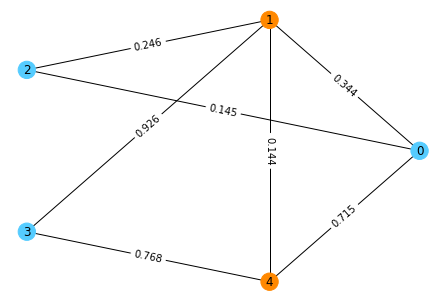

In [13]:
colormap = ["#55CCFF", "#FF8800"]

# create networkx graph
G = nx.Graph()
for i in range(nqubits):
    G.add_node(i, color = colormap[int(maxcut[i])])
for i in range(len(edges)):
    G.add_edge(edges[i][0], edges[i][1], weight = weights[i])

# draw networkx
pos = nx.circular_layout(G)
color = nx.get_node_attributes(G, "color")
labels = nx.get_edge_attributes(G, "weight")
nx.draw(G, pos, node_color=color.values(), with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);